In [3]:
import pandas as pd
import numpy as np
import json
import glob

#Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

#spacy
import spacy
from nltk.corpus import stopwords

#vis
import pyLDAvis
import pyLDAvis.gensim


In [9]:
df = pd.read_pickle('gcse_specs.pkl')

In [11]:
from gensim import corpora

# Step 1: Generate data_words
data_words = df['Processed_Text'].apply(lambda x: x.split()).tolist()

# Step 2: Create id2word dictionary
id2word = corpora.Dictionary(data_words)

# Step 3: Create the corpus
corpus = [id2word.doc2bow(text) for text in data_words]


In [13]:
#BIGRAMS AND TRIGRAMS
bigram_phrases = gensim.models.Phrases(data_words, min_count=5, threshold=75)
trigram_phrases = gensim.models.Phrases(bigram_phrases[data_words], threshold=75)

bigram = gensim.models.phrases.Phraser(bigram_phrases)
trigram = gensim.models.phrases.Phraser(trigram_phrases)

def make_bigrams(texts):
    return([bigram[doc] for doc in texts])

def make_trigrams(texts):
    return ([trigram[bigram[doc]] for doc in texts])

data_bigrams = make_bigrams(data_words)
data_bigrams_trigrams = make_trigrams(data_bigrams)

In [15]:
#TF-IDF REMOVAL
from gensim.models import TfidfModel

id2word = corpora.Dictionary(data_bigrams_trigrams)

texts = data_bigrams_trigrams

corpus = [id2word.doc2bow(text) for text in texts]
# print (corpus[0][0:20])

tfidf = TfidfModel(corpus, id2word=id2word)

low_value = 0.03
words  = []
words_missing_in_tfidf = []
for i in range(0, len(corpus)):
    bow = corpus[i]
    low_value_words = [] #reinitialize to be safe. You can skip this.
    tfidf_ids = [id for id, value in tfidf[bow]]
    bow_ids = [id for id, value in bow]
    low_value_words = [id for id, value in tfidf[bow] if value < low_value]
    drops = low_value_words+words_missing_in_tfidf
    for item in drops:
        words.append(id2word[item])
    words_missing_in_tfidf = [id for id in bow_ids if id not in tfidf_ids] # The words with tf-idf socre 0 will be missing

    new_bow = [b for b in bow if b[0] not in low_value_words and b[0] not in words_missing_in_tfidf]
    corpus[i] = new_bow

In [21]:
from gensim import corpora
from gensim.models import TfidfModel

# Initialize the dictionary and corpus
id2word = corpora.Dictionary(data_bigrams_trigrams)
texts = data_bigrams_trigrams
corpus = [id2word.doc2bow(text) for text in texts]

# Create the TF-IDF model
tfidf = TfidfModel(corpus, id2word=id2word)

# Define the low-value threshold
low_value = 0.03

# Initialize lists to collect removed words
removed_words = set()  # Use a set to avoid duplicates

# Iterate over the corpus to identify low-value words and missing words
for bow in corpus:
    tfidf_bow = tfidf[bow]
    
    # Extract IDs of words with low TF-IDF values
    low_value_ids = [id for id, value in tfidf_bow if value < low_value]
    
    # Extract IDs of words present in the BOW but not in the TF-IDF model (i.e., zero TF-IDF)
    tfidf_ids = set(id for id, value in tfidf_bow)
    bow_ids = set(id for id, value in bow)
    missing_in_tfidf_ids = bow_ids - tfidf_ids
    
    # Add the words with low TF-IDF values and missing TF-IDF values to the removed words list
    removed_words.update(low_value_ids)
    removed_words.update(missing_in_tfidf_ids)

# Convert IDs to words
removed_words_list = [id2word[id] for id in removed_words]

# Optionally, print or save the removed words
print("Removed Words:")
for word in removed_words_list:
    print(word)

# If you need to update the corpus
updated_corpus = []
for bow in corpus:
    tfidf_bow = tfidf[bow]
    low_value_ids = set(id for id, value in tfidf_bow if value < low_value)
    missing_in_tfidf_ids = set(id for id in bow if id not in tfidf_bow)
    
    new_bow = [b for b in bow if b[0] not in low_value_ids and b[0] not in missing_in_tfidf_ids]
    updated_corpus.append(new_bow)

# Updated corpus now contains the BOW representation with low-value words removed


Removed Words:
aa
aaa
aamn
ability
able
acceleration
access
access_advisor
access_arrangement
access_planning
access_script
access_selection_generic
accessibility
accessible
accuracy
accurate
accurately
achieve
achievement
acquire
active
activity
activity_suggestion
acute
adapt
add
add_together
addition
addition_subtraction
adjustment
advantage
advantage_disadvantage
advisor
affect
age
agency_department_play
aid
aim
aim_encourage
algebra
algebraic
allocation
allow
already
also
alternate
always_website_differ
amount
analyse
analysis
analysis_service
analytical
angle
angle_triangle
answer
anti
aoii
appeal
appear
appendix_descriptor
application
apply
appreciate
approach
appropriate
appropriately
approve_examination
approximate
approximation
arc
area
argument
arithmetic
arrange
arrangement
arrangement_govern
arrangement_improve_resilience
aspect
assess
assessment
assessmentinclusion_disclaimer_regard_availability
assist
assume
assumption
attain
attitude
attribute
authentic
availability
ava

In [ ]:
from gensim import corpora
from gensim.models import TfidfModel, LdaModel
from gensim.models import CoherenceModel
import matplotlib.pyplot as plt
import numpy as np

# Define a range of low-value thresholds to test
thresholds = [0.01, 0.03, 0.05, 0.1, 0.2]

# Define the number of topics for the LDA model
num_topics = 6

# Initialize lists to store coherence values and corresponding thresholds
coherence_values = []
thresholds_used = []

# Original corpus
id2word = corpora.Dictionary(data_bigrams_trigrams)
texts = data_bigrams_trigrams
corpus = [id2word.doc2bow(text) for text in texts]

# Iterate over each threshold value
for low_value in thresholds:
    # Create TF-IDF model
    tfidf = TfidfModel(corpus, id2word=id2word)
    
    # Filter words based on TF-IDF score
    filtered_corpus = []
    for bow in corpus:
        tfidf_bow = tfidf[bow]
        low_value_ids = set(id for id, value in tfidf_bow if value < low_value)
        new_bow = [b for b in bow if b[0] not in low_value_ids]
        filtered_corpus.append(new_bow)
    
    # Train LDA model
    lda_model = LdaModel(
        corpus=filtered_corpus,
        id2word=id2word,
        num_topics=num_topics,
        alpha='auto',
        eta='auto',
        passes=50,
        random_state=100
    )
    
    # Compute coherence score
    coherence_model = CoherenceModel(
        model=lda_model,
        texts=texts,
        dictionary=id2word,
        coherence='c_v'
    )
    coherence_score = coherence_model.get_coherence()
    
    # Store the results
    coherence_values.append(coherence_score)
    thresholds_used.append(low_value)

# Plot coherence scores against thresholds
plt.figure(figsize=(10, 6))
plt.plot(thresholds_used, coherence_values, marker='o')
plt.xlabel("Low Value Threshold")
plt.ylabel("Coherence Score (C_v)")
plt.title("Coherence Score vs. Low Value Threshold")
plt.xscale('log')  # Optional: Use log scale if thresholds span several orders of magnitude
plt.grid(True)
plt.show()

# Print results
for threshold, score in zip(thresholds_used, coherence_values):
    print(f"Threshold: {threshold}, Coherence Score: {score}")


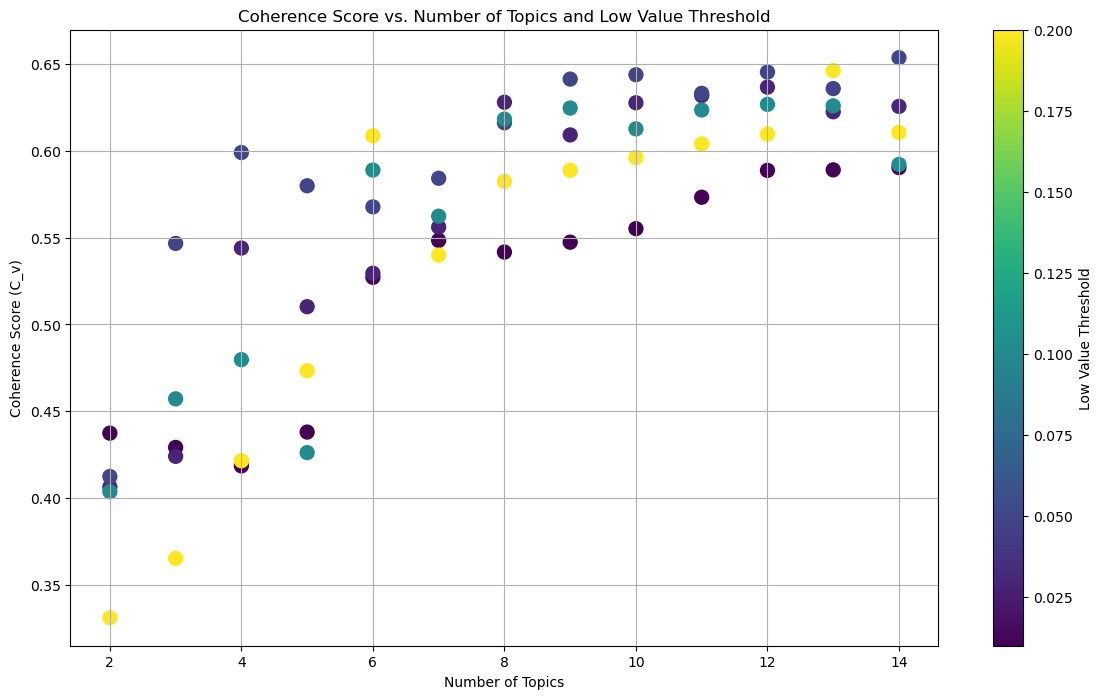

Threshold: 0.01, Number of Topics: 2.0, Coherence Score: 0.4373996700599875
Threshold: 0.01, Number of Topics: 3.0, Coherence Score: 0.4291923811551517
Threshold: 0.01, Number of Topics: 4.0, Coherence Score: 0.4185699148607025
Threshold: 0.01, Number of Topics: 5.0, Coherence Score: 0.4380256941742314
Threshold: 0.01, Number of Topics: 6.0, Coherence Score: 0.5271322401896394
Threshold: 0.01, Number of Topics: 7.0, Coherence Score: 0.5483977053819892
Threshold: 0.01, Number of Topics: 8.0, Coherence Score: 0.5416671839072953
Threshold: 0.01, Number of Topics: 9.0, Coherence Score: 0.5473623953941488
Threshold: 0.01, Number of Topics: 10.0, Coherence Score: 0.555161672611187
Threshold: 0.01, Number of Topics: 11.0, Coherence Score: 0.5732599820644766
Threshold: 0.01, Number of Topics: 12.0, Coherence Score: 0.5887167200874598
Threshold: 0.01, Number of Topics: 13.0, Coherence Score: 0.5890055163129172
Threshold: 0.01, Number of Topics: 14.0, Coherence Score: 0.5903094151823157
Threshol

In [26]:
from gensim import corpora
from gensim.models import TfidfModel, LdaModel
from gensim.models import CoherenceModel
import matplotlib.pyplot as plt
import numpy as np

# Define ranges for low-value thresholds and number of topics
thresholds = [0.01, 0.03, 0.05, 0.1, 0.2]
num_topics_range = range(2, 15, 1)  

# Initialize lists to store results
coherence_values = []
params = []

# Original corpus
id2word = corpora.Dictionary(data_bigrams_trigrams)
texts = data_bigrams_trigrams
corpus = [id2word.doc2bow(text) for text in texts]

# Iterate over each combination of threshold and number of topics
for low_value in thresholds:
    for num_topics in num_topics_range:
        # Create TF-IDF model
        tfidf = TfidfModel(corpus, id2word=id2word)
        
        # Filter words based on TF-IDF score
        filtered_corpus = []
        for bow in corpus:
            tfidf_bow = tfidf[bow]
            low_value_ids = set(id for id, value in tfidf_bow if value < low_value)
            new_bow = [b for b in bow if b[0] not in low_value_ids]
            filtered_corpus.append(new_bow)
        
        # Train LDA model
        lda_model = gensim.models.LdaModel(
            corpus=filtered_corpus,
            id2word=id2word,
            num_topics=num_topics,
            alpha='auto',
            update_every=1,
            chunksize=10,
            passes=50,
            random_state=100
        )
        
        # Compute coherence score
        coherence_model = CoherenceModel(
            model=lda_model,
            texts=texts,
            dictionary=id2word,
            coherence='c_v'
        )
        coherence_score = coherence_model.get_coherence()
        
        # Store the results
        coherence_values.append(coherence_score)
        params.append((low_value, num_topics))

# Convert results to numpy arrays for easier manipulation
coherence_values = np.array(coherence_values)
params = np.array(params)

# Plot coherence scores against thresholds and number of topics
plt.figure(figsize=(14, 8))
scatter = plt.scatter(params[:, 1], coherence_values, c=params[:, 0], cmap='viridis', s=100)
plt.colorbar(scatter, label='Low Value Threshold')
plt.xlabel('Number of Topics')
plt.ylabel('Coherence Score (C_v)')
plt.title('Coherence Score vs. Number of Topics and Low Value Threshold')
plt.grid(True)
plt.show()

# Print results
for (threshold, num_topics), score in zip(params, coherence_values):
    print(f"Threshold: {threshold}, Number of Topics: {num_topics}, Coherence Score: {score}")
